<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/02_Exploratory_Data_Analysis/Topic_Modelling_BERTopic_Llama2.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>


# Topic Modelling - BERTopic and Llama2

## 1. Introduction

BERTopic, introduced by [Maarten Grootendorst](https://arxiv.org/abs/2203.05794) in 2022, is a modular topic modelling technique that leverages sentence-transformer embeddings, clustering models and a class-based TF-IDF procedure to create dense clusters allowing for easily interpretable topics.

We will be following the [BERTopic tutorial](https://towardsdatascience.com/topic-modeling-with-llama-2-85177d01e174) and accompanying [colab notebook](https://colab.research.google.com/drive/1QCERSMUjqGetGGujdrvv_6_EeoIcd_9M?usp=sharing) to apply this topic modelling technique to the PubMed Central and arXiv article titles in our dataset, and fine-tuning the topic representations by prompting Llama2 to create short topic labels.

The workflow comprises six sequential steps as follows: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, extract the best representing words per topic, and fine-tune topic representations with Llama2.

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/alisonmitchell/Biomedical-Knowledge-Graph/main/02_Exploratory_Data_Analysis/images/BERTopic_Llama2.png"
         alt="BERTopic and Llama2 steps"  width="500" height="auto">
  </td></tr>
  <tr><td align="center">
    Llama 2 lets us fine-tune the topic representations generated by BERTopic.<br/>Source: <a href="https://towardsdatascience.com/topic-modeling-with-llama-2-85177d01e174">https://towardsdatascience.com/topic-modeling-with-llama-2-85177d01e174</a>.<br/>&nbsp;
  </td></tr>
</table>




## 2. Install/import libraries

In [ ]:
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [ ]:
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")

from datasets import Dataset
from datasets import load_dataset

## 3. Load data

In [ ]:
with open('2024-02-20_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.pickle', 'rb') as f:
    pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated = pickle.load(f)

In [ ]:
len(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated)

11687

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11687 entries, 0 to 11686
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     11687 non-null  object
 1   published      11687 non-null  object
 2   revised        11687 non-null  object
 3   title          11687 non-null  object
 4   title_cleaned  11687 non-null  object
 5   journal        11426 non-null  object
 6   authors        11687 non-null  object
 7   doi            11450 non-null  object
 8   pdf_url        11687 non-null  object
 9   text           11687 non-null  object
dtypes: object(10)
memory usage: 913.2+ KB


We are going to apply topic modelling on the article titles and will create a DataFrame with  these and their corresponding journal titles.

In [ ]:
# Select specific columns from the DataFrame
columns_to_select = ['title_cleaned', 'journal']
new_df = pmc_arxiv_full_text_merged_plus_cleaned_article_titles_updated[columns_to_select]

We will convert the pandas DataFrame to a HuggingFace dataset object.



In [ ]:
dataset = Dataset.from_pandas(new_df)

In [ ]:
# Extract article titles to train on and corresponding journals
article_titles = dataset["title_cleaned"]
journal_titles = dataset["journal"]

In [ ]:
print(journal_titles[4])
print(article_titles[4])

Biology
Drug Repurposing Using Gene Co-Expression and Module Preservation Analysis in Acute Respiratory Distress Syndrome (ARDS), Systemic Inflammatory Response Syndrome (SIRS), Sepsis, and COVID-19.


## 4. HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## 5. Llama 2

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-13b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-13b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


In [ ]:
!nvidia-smi

Tue Mar 19 21:55:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 6. Optimization & Quantization

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Temperature has been set to 0.1 as if you try temperature=0 you will get ValueError: `temperature` (=0.0) has to be a strictly positive float, otherwise your next token scores will be invalid. If you're looking for greedy decoding strategies, set `do_sample=False`.

## 7. Prompt Engineering

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [ ]:
prompt = "Could you explain to me about COVID-19?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me about COVID-19?

Sure, I'd be happy to help! COVID-19 is a respiratory illness caused by the SARS-CoV-2 virus. It was first identified in Wuhan, China in December 2019, and has since spread to become a global pandemic.

Here are some key things to know about COVID-19:

1. Symptoms: The symptoms of COVID-19 can range from mild to severe and include fever, cough, shortness of breath, and fatigue. In more severe cases, it can cause pneumonia, acute respiratory distress syndrome (ARDS), and even death.
2. Transmission: COVID-19 is primarily spread through close contact with an infected person, such as touching or shaking hands. It can also be spread through respiratory droplets that are produced when an infected person talks, coughs, or sneezes.
3. Incubation period: The incubation period for COVID-19 is typically between 2-14 days, which means that a person can be infected with the virus and not show any symptoms for up to two weeks.
4. Testing: There are several t

LLMs are non-deterministic despite setting the temperature parameter to be quite low, so another attempt yielded a slightly different response.

In [ ]:
prompt = "Could you explain to me about COVID-19?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me about COVID-19?

I'm just an AI, I don't have personal experiences or emotions, but I can certainly help you understand more about COVID-19.

COVID-19 is a respiratory illness caused by the SARS-CoV-2 virus. It was first identified in Wuhan, China in December 2019 and has since spread to become a global pandemic. The virus is highly contagious and can be transmitted through respiratory droplets when an infected person talks, coughs, or sneezes. It can also be spread by touching surfaces or objects that have the virus on them, and then touching one's face.

Symptoms of COVID-19 can include fever, cough, shortness of breath, and fatigue. In more severe cases, it can cause pneumonia, acute respiratory distress syndrome, and even death.

The best way to prevent the spread of COVID-19 is through social distancing, wearing masks, washing hands regularly, and avoiding close contact with people who are sick. Vaccination is also an effective way to prevent the spread of 

Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

Next, let's see how we can use this template to optimize Llama 2 for topic modeling.

### 7.1 Prompt Template

We are going to keep our `system prompt` simple and to the point:

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labelling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- In general, a resting heart rate over 100 beats per minute is accepted as tachycardia in adults.
- Paroxysmal tachycardia is a form of tachycardia which begins and ends in an acute (or paroxysmal) manner.
- Supraventricular tachycardia (SVT) is an umbrella term for fast heart rhythms arising from the upper part of the heart.
- Ventricular tachycardia (V-tach or VT) is a cardiovascular disorder in which fast heart rate occurs in the ventricles of the heart.

The topic is described by the following keywords: 'tachycardia, heart, rate, beats, rhythms, paroxysmal, ventricle, ventricular, supraventricular, cardiovascular, disorder'.

Based on the information about the topic above, please create a short label of this topic. Make sure you only return the label and nothing more.

[/INST] Tachycardia
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

## 8. BERTopic

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

### 8.1 Preparing Embeddings

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(article_titles, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/366 [00:00<?, ?it/s]

### 8.2 Sub-models

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

The default dimensionality reduction algorithm is [UMAP](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#umap), an unsupervised, non-linear dimensionality reduction algorithm which preserves local and global structure and clustering patterns.

After reducing the embeddings with UMAP, the default clustering algorithm used is [HDBSCAN](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#hdbscan), a density-based clustering model. It identifies the number of clustering automatically, and does not require specifying the number of clusters beforehand.

However, [`min_cluster_size`](https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#min_cluster_size) is arguably the most important parameter in HDBSCAN as it controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. The documentation advises increasing this value rather than decreasing it.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### 8.3 Representation Models

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using [c-TF-IDF](https://maartengr.github.io/BERTopic/api/ctfidf.html) as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

c-TF-IDF is a class-based TF-IDF procedure using scikit-learn's TfidfTransformer as a base. In TF-IDF, TF measures the term frequency in each document, whereas in c-TF-IDF, TF measures the term frequency in each cluster, and each cluster includes many documents.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

## 9. Training

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  n_gram_range=(1,3),
  nr_topics="auto",
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(article_titles, embeddings)

2024-03-19 23:30:29,783 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-19 23:30:48,313 - BERTopic - Dimensionality - Completed ✓
2024-03-19 23:30:48,316 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-19 23:30:49,067 - BERTopic - Cluster - Completed ✓
2024-03-19 23:30:49,069 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 160/160 [23:21<00:00,  8.76s/it]
2024-03-19 23:54:27,568 - BERTopic - Representation - Completed ✓
2024-03-19 23:54:27,579 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 34/34 [04:40<00:00,  8.26s/it]
2024-03-19 23:59:13,346 - BERTopic - Topic reduction - Reduced number of topics from 160 to 34


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,5385,-1_of_and_in_the,"[of, and, in, the, sars, cov, sars cov, for, c...","[against sars cov, drug repurposing, sars cov,...","[COVID-19 Treatment, , , , , , , , , ]","[of, and, in, the, sars, cov, sars cov, for, c...",[Repurposing existing drugs for the treatment ...
1,0,4592,0_of_and_the_covid,"[of, and, the, covid, 19, covid 19, sars, cov,...","[drug discovery, against sars cov, drug repurp...","[COVID-19 Treatment, , , , , , , , , ]","[of, and, the, covid, 19, covid 19, sars, cov,...","[Drug repurposing against SARS-CoV-1, SARS-CoV..."
2,1,933,1_alzheimer_alzheimer disease_disease_cognitive,"[alzheimer, alzheimer disease, disease, cognit...","[in alzheimer disease, alzheimer disease, alzh...","[Alzheimer's Disease, , , , , , , , , ]","[alzheimer, alzheimer disease, disease, cognit...",[Using normative modelling to detect disease p...
3,2,211,2_health_artificial intelligence_intelligence_...,"[health, artificial intelligence, intelligence...","[artificial intelligence and, artificial intel...","[Artificial Intelligence in Healthcare, , , , ...","[health, artificial intelligence, intelligence...",[Artificial intelligence and machine learning ...
4,3,67,3_innovation_pharmaceutical_the_in,"[innovation, pharmaceutical, the, in, and, res...","[pharmaceutical industry, pharmaceutical indus...","[Pharmaceutical Innovation, , , , , , , , , ]","[innovation, pharmaceutical, the, in, and, res...",[Development of a core evaluation framework of...
5,4,39,4_ivermectin_of ivermectin_ivermectin for_of,"[ivermectin, of ivermectin, ivermectin for, of...","[ivermectin for covid, covid 19 ivermectin, iv...","[Ivermectin for COVID-19 Treatment, , , , , , ...","[ivermectin, of ivermectin, ivermectin for, of...",[Prospective mode of action of Ivermectin: SAR...
6,5,35,5_on chip_chip_on_organ on,"[on chip, chip, on, organ on, organ on chip, o...","[organ on chip, organs on chips, chip technolo...","[Organ-on-a-Chip, , , , , , , , , ]","[on chip, chip, on, organ on, organ on chip, o...",[Organ-on-a-Chip systems for new drugs develop...
7,6,30,6_depression_treatment resistant_for_schizophr...,"[depression, treatment resistant, for, schizop...","[neuropsychiatric drug discovery, treatment re...","[Treatment-Resistant Schizophrenia, , , , , , ...","[depression, treatment resistant, for, schizop...",[Glycine Signaling in the Framework of Dopamin...
8,7,29,7_synthesis_synthesis of_of_radical,"[synthesis, synthesis of, of, radical, synthet...","[photochemical arylation, organic synthesis, p...","[Green Chemistry Synthesis, , , , , , , , , ]","[synthesis, synthesis of, of, radical, synthet...",[Technological Innovations in Photochemistry f...
9,8,28,8_biomedical_knowledge_knowledge graph_graph,"[biomedical, knowledge, knowledge graph, graph...","[biomedical knowledge graph, biomedical knowle...","[Biomedical Knowledge Graph, , , , , , , , , ]","[biomedical, knowledge, knowledge graph, graph...",[Tracking biomedical articles along the transl...


In [ ]:
topic_model_34_df = topic_model.get_topic_info()

In [ ]:
with open('2024-03-19_topic_model_34_df.pickle', 'wb') as f:
  pickle.dump(topic_model_34_df, f)

We will look at all representations for a few topics and see the keywords and weightings of the various models, and the Llama 2 labels.

In [ ]:
topic_model.get_topic(0, full=True)

{'Main': [('of', 0.017791472460179467),
  ('and', 0.015847634542708423),
  ('the', 0.012884873722522446),
  ('covid', 0.01274839967000902),
  ('19', 0.012713071157520123),
  ('covid 19', 0.012638681293705649),
  ('sars', 0.01259049859453911),
  ('cov', 0.012487844046888935),
  ('sars cov', 0.012398886020761862),
  ('for', 0.011556730761794767)],
 'KeyBERT': [('drug discovery', 0.9129371),
  ('against sars cov', 0.90833896),
  ('drug repurposing', 0.9064613),
  ('cov main protease', 0.8974907),
  ('for covid 19', 0.8970081),
  ('the sars cov', 0.8964425),
  ('sars cov', 0.8934491),
  ('for covid', 0.89188266),
  ('against sars', 0.89186454),
  ('sars cov main', 0.8910687)],
 'Llama2': [('COVID-19 Treatment', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 'MMR': [('of', 0.017791472460179467),
  ('and', 0.015847634542708423),
  ('the', 0.012884873722522446),
  ('covid', 0.01274839967000902),
  ('19', 0.012713071157520123),
  ('covi

We can also access output for a particular representation model e.g. KeyBERT.

In [ ]:
topic_model.get_topic(0, full=True)["KeyBERT"]

[('drug discovery', 0.9129371),
 ('against sars cov', 0.90833896),
 ('drug repurposing', 0.9064613),
 ('cov main protease', 0.8974907),
 ('for covid 19', 0.8970081),
 ('the sars cov', 0.8964425),
 ('sars cov', 0.8934491),
 ('for covid', 0.89188266),
 ('against sars', 0.89186454),
 ('sars cov main', 0.8910687)]

In [ ]:
topic_model.get_topic(12, full=True)

{'Main': [('omicron', 0.13666763188803202),
  ('ba', 0.09555982407528753),
  ('variant', 0.06848933348641),
  ('omicron variant', 0.05418806789757178),
  ('cov omicron', 0.047779912037643764),
  ('sars cov omicron', 0.047779912037643764),
  ('omicron ba', 0.04466625545745705),
  ('of omicron', 0.035733004365965645),
  ('529', 0.03441549999178581),
  ('and', 0.02944221763082505)],
 'KeyBERT': [('sars cov omicron', 0.9382565),
  ('cov omicron ba', 0.91896427),
  ('cov omicron', 0.91783595),
  ('cov omicron variant', 0.91417027),
  ('omicron variant host', 0.9070536),
  ('the sars cov', 0.9041238),
  ('omicron ba', 0.9024912),
  ('omicron', 0.9014518),
  ('omicron variant', 0.894845),
  ('sars cov', 0.8943654)],
 'Llama2': [('SARS-CoV-2 Omicron Variant', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 'MMR': [('omicron', 0.13666763188803202),
  ('ba', 0.09555982407528753),
  ('variant', 0.06848933348641),
  ('omicron variant', 0.054

In [ ]:
topic_model.get_topic(15, full=True)

{'Main': [('the', 0.03929211772892844),
  ('next', 0.0376285466816804),
  ('genomics', 0.03614368251638824),
  ('generation', 0.035583812252607754),
  ('genomic', 0.03532194037246213),
  ('of next generation', 0.03376154958638678),
  ('bioinformatics', 0.0336496469523407),
  ('of next', 0.032843544778847045),
  ('generation sequencing', 0.03209353169906174),
  ('the pharmaceutical', 0.030425795069683344)],
 'KeyBERT': [('in genomic medicine', 0.94404703),
  ('modern genomics', 0.94134426),
  ('genomics for drug', 0.9404826),
  ('genome based testing', 0.9396554),
  ('in cancer genomics', 0.9378939),
  ('modern genomics the', 0.9367787),
  ('national genomic project', 0.9350159),
  ('in genomics for', 0.9336208),
  ('genomic project', 0.9335372),
  ('genomics', 0.9335114)],
 'Llama2': [('Next Generation Genomics', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 'MMR': [('the', 0.03929211772892844),
  ('next', 0.0376285466816804),


In [ ]:
topic_model.get_topic(25, full=True)

{'Main': [('neurofilament light', 0.1532664767460623),
  ('neurofilament', 0.1532664767460623),
  ('light', 0.13425959964715017),
  ('neurofilament light chain', 0.07824491550254736),
  ('light chain', 0.07824491550254736),
  ('plasma neurofilament light', 0.06434554156464303),
  ('plasma neurofilament', 0.06434554156464303),
  ('chain', 0.06287905739418934),
  ('plasma', 0.05313849485020675),
  ('light in', 0.04995100137755971)],
 'KeyBERT': [('neurofilament light chain', 0.9486208),
  ('plasma neurofilament light', 0.93819445),
  ('neurofilament light', 0.9377917),
  ('neurofilament light based', 0.9375525),
  ('disease plasma neurofilament', 0.9367412),
  ('in plasma neurofilament', 0.93443406),
  ('neurofilament light in', 0.93408024),
  ('plasma neurofilament', 0.93300086),
  ('of neurofilament light', 0.930773),
  ('neurofilament', 0.92296576)],
 'Llama2': [('Neurofilament Light Chain Biomarkers', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  

In [ ]:
topic_model.get_topic(30, full=True)

{'Main': [('monkeypox', 0.18104107295513458),
  ('monkeypox virus', 0.08313522272145657),
  ('against monkeypox', 0.046338890363841104),
  ('against monkeypox virus', 0.046338890363841104),
  ('inositol', 0.046338890363841104),
  ('for monkeypox', 0.046338890363841104),
  ('monkeypox outbreak', 0.04422744913638099),
  ('virus', 0.03900736401045775),
  ('outbreak', 0.031749086262667835),
  ('monkeypox virus proteins', 0.02497433784714523)],
 'KeyBERT': [('monkeypox virus computational', 0.94855934),
  ('against monkeypox virus', 0.93454206),
  ('for monkeypox virus', 0.9332482),
  ('monkeypox primate lentiviruses', 0.9321157),
  ('monkeypox virus proteins', 0.9284195),
  ('monkeypox virus molecular', 0.9273824),
  ('monkeypox virus', 0.92370707),
  ('for emerging monkeypox', 0.9222306),
  ('for monkeypox', 0.9209024),
  ('monkeypox virus monkeypox', 0.92006564)],
 'Llama2': [('Monkeypox Virus', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
 

We got 34 topics that were created. We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF and appear as the top 3 words underscore separated, but we will focus on the Llama 2 representations instead using `.set_topic_labels` to update the topic labels.





In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

If we were to run `topic_model.get_topic_info()` it will now include the column CustomName. That is the [custom label](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#training) that we just created for each topic.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,5385,-1_of_and_in_the,COVID-19 Treatment,"[of, and, in, the, sars, cov, sars cov, for, c...","[against sars cov, drug repurposing, sars cov,...","[COVID-19 Treatment, , , , , , , , , ]","[of, and, in, the, sars, cov, sars cov, for, c...",[Repurposing existing drugs for the treatment ...
1,0,4592,0_of_and_the_covid,COVID-19 Treatment,"[of, and, the, covid, 19, covid 19, sars, cov,...","[drug discovery, against sars cov, drug repurp...","[COVID-19 Treatment, , , , , , , , , ]","[of, and, the, covid, 19, covid 19, sars, cov,...","[Drug repurposing against SARS-CoV-1, SARS-CoV..."
2,1,933,1_alzheimer_alzheimer disease_disease_cognitive,Alzheimer's Disease,"[alzheimer, alzheimer disease, disease, cognit...","[in alzheimer disease, alzheimer disease, alzh...","[Alzheimer's Disease, , , , , , , , , ]","[alzheimer, alzheimer disease, disease, cognit...",[Using normative modelling to detect disease p...
3,2,211,2_health_artificial intelligence_intelligence_...,Artificial Intelligence in Healthcare,"[health, artificial intelligence, intelligence...","[artificial intelligence and, artificial intel...","[Artificial Intelligence in Healthcare, , , , ...","[health, artificial intelligence, intelligence...",[Artificial intelligence and machine learning ...
4,3,67,3_innovation_pharmaceutical_the_in,Pharmaceutical Innovation,"[innovation, pharmaceutical, the, in, and, res...","[pharmaceutical industry, pharmaceutical indus...","[Pharmaceutical Innovation, , , , , , , , , ]","[innovation, pharmaceutical, the, in, and, res...",[Development of a core evaluation framework of...
5,4,39,4_ivermectin_of ivermectin_ivermectin for_of,Ivermectin for COVID-19 Treatment,"[ivermectin, of ivermectin, ivermectin for, of...","[ivermectin for covid, covid 19 ivermectin, iv...","[Ivermectin for COVID-19 Treatment, , , , , , ...","[ivermectin, of ivermectin, ivermectin for, of...",[Prospective mode of action of Ivermectin: SAR...
6,5,35,5_on chip_chip_on_organ on,Organ-on-a-Chip,"[on chip, chip, on, organ on, organ on chip, o...","[organ on chip, organs on chips, chip technolo...","[Organ-on-a-Chip, , , , , , , , , ]","[on chip, chip, on, organ on, organ on chip, o...",[Organ-on-a-Chip systems for new drugs develop...
7,6,30,6_depression_treatment resistant_for_schizophr...,Treatment-Resistant Schizophrenia,"[depression, treatment resistant, for, schizop...","[neuropsychiatric drug discovery, treatment re...","[Treatment-Resistant Schizophrenia, , , , , , ...","[depression, treatment resistant, for, schizop...",[Glycine Signaling in the Framework of Dopamin...
8,7,29,7_synthesis_synthesis of_of_radical,Green Chemistry Synthesis,"[synthesis, synthesis of, of, radical, synthet...","[photochemical arylation, organic synthesis, p...","[Green Chemistry Synthesis, , , , , , , , , ]","[synthesis, synthesis of, of, radical, synthet...",[Technological Innovations in Photochemistry f...
9,8,28,8_biomedical_knowledge_knowledge graph_graph,Biomedical Knowledge Graph,"[biomedical, knowledge, knowledge graph, graph...","[biomedical knowledge graph, biomedical knowle...","[Biomedical Knowledge Graph, , , , , , , , , ]","[biomedical, knowledge, knowledge graph, graph...",[Tracking biomedical articles along the transl...


In [ ]:
topic_model_34_custom_df = topic_model.get_topic_info()

In [ ]:
with open('2024-03-19_topic_model_34_custom_df.pickle', 'wb') as f:
  pickle.dump(topic_model_34_custom_df, f)

We can now access the 34 Llama 2 custom labels.

In [ ]:
topic_model.custom_labels_

['COVID-19 Treatment',
 'COVID-19 Treatment',
 "Alzheimer's Disease",
 'Artificial Intelligence in Healthcare',
 'Pharmaceutical Innovation',
 'Ivermectin for COVID-19 Treatment',
 'Organ-on-a-Chip',
 'Treatment-Resistant Schizophrenia',
 'Green Chemistry Synthesis',
 'Biomedical Knowledge Graph',
 'Pharmacokinetics',
 'Data Science',
 'Pharmacy Education',
 'SARS-CoV-2 Omicron Variant',
 'Venom Research',
 'Extracellular Vesicles',
 'Next Generation Genomics',
 '3D Bioprinting',
 'Endophytic Fungi',
 'Single Cell Analysis',
 'Blood-Brain Barrier',
 'COVID-19',
 'Molnupiravir for COVID-19',
 'Andrographolide',
 'Nitazoxanide for COVID-19 Treatment',
 'Brain Organoids',
 'Neurofilament Light Chain Biomarkers',
 'Microbiome Research',
 'Niclosamide as Antiviral Agent',
 'Baricitinib and COVID-19',
 'Propolis and COVID-19',
 'Monkeypox Virus',
 'COVID-19 Stem Cell Therapy',
 'Ion Channels']

## 10. Visualize

We can go through each topic manually or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

We can show the updated labels in visualizations with the `custom_labels=True` parameters.

In [ ]:
# Visualise journal titles

topic_model.visualize_documents(journal_titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
# Visualise article titles

topic_model.visualize_documents(article_titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in article_titles]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [ ]:
df

,x,y,Topic,Length
1,-2.930130,3.101272,0,101
2,-2.423558,6.079807,21,63
3,-1.446319,6.644914,0,93
5,-2.727311,3.968897,0,88
7,-2.809809,2.671765,0,111
...,...,...,...,...
11678,-1.870150,1.927017,0,85
11679,-0.803038,3.184955,0,75
11682,-1.472719,5.935493,0,142
11683,-1.499021,5.577275,0,104


In [ ]:
with open('2024-03-19_x_y_topic_length.pickle', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
mean_df

,Topic,x,y,Length
0,0,0.963380,6.560756,105.740790
1,1,8.826457,5.846133,110.100750
12,2,5.500827,5.335339,91.436019
23,3,5.310913,5.233978,96.761194
27,4,-4.472306,6.049839,113.025641
28,5,6.881295,9.002122,84.514286
29,6,7.502306,6.512753,100.766667
30,7,4.227835,7.818861,94.034483
31,8,6.188381,5.654177,101.035714
32,9,6.310176,6.855567,124.333333


In [ ]:
with open('2024-03-19_mean_df.pickle', 'wb') as f:
  pickle.dump(mean_df, f)

In [ ]:
len(topic_model.topics_)

11687

In [ ]:
topics = topic_model.topics_

In [ ]:
with open('2024-03-19_topic_model_34_topics.pickle', 'wb') as f:
  pickle.dump(topics, f)

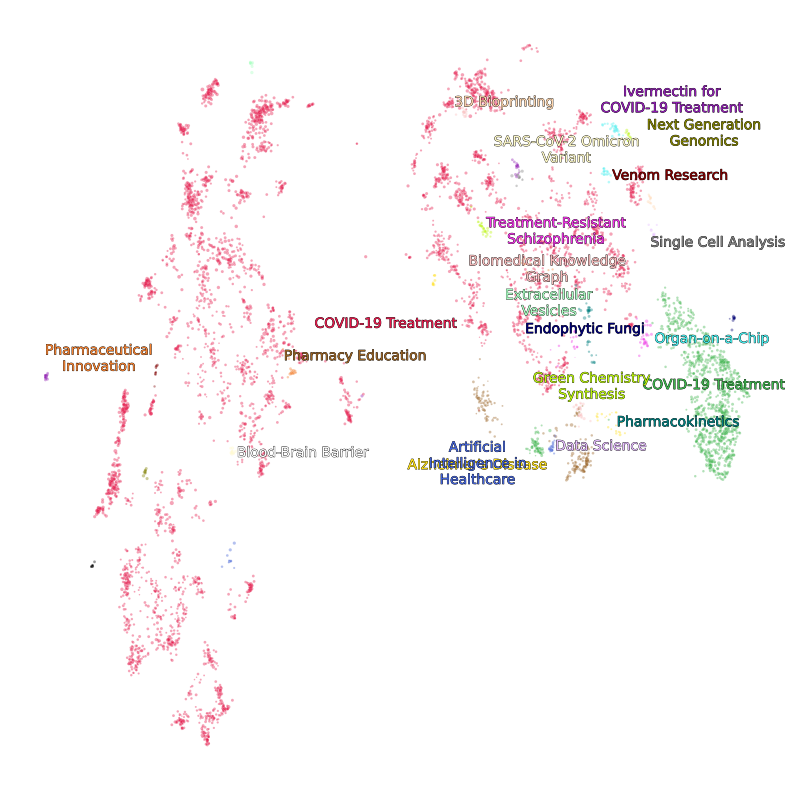

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='Topic', palette=color_key.values(), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 20 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
    topic = row[1]["Topic"]
    name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

    if int(topic) <= 20:
        xs.append(row[1]["x"])
        ys.append(row[1]["y"])
        texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                              path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                              ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

### References

* Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. [arXiv:2203.05794](https://arxiv.org/pdf/2203.05794)

* https://towardsdatascience.com/topic-modeling-with-llama-2-85177d01e174

* https://colab.research.google.com/drive/1QCERSMUjqGetGGujdrvv_6_EeoIcd_9M?usp=sharing#scrollTo=rbwHbJc_YXi8

* https://www.youtube.com/watch?v=5a5Dfft-rWc

* https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

* https://towardsdatascience.com/bertopic-what-is-so-special-about-v0-16-64d5eb3783d9

* https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

* https://grabngoinfo.com/hyperparameter-tuning-for-bertopic-model-in-python/

* https://discuss.huggingface.co/t/trying-to-understand-system-prompts-with-llama-2-and-transformers-interface/59016/8

* https://medium.com/@eboraks/llama-2-prompt-engineering-extracting-information-from-articles-examples-45158ff9bd23

* https://gpus.llm-utils.org/llama-2-prompt-template/

* https://discuss.huggingface.co/t/how-to-calculate-embeddings-with-llama-2-model/57026/4
